In [14]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_bvp
from scipy.optimize import root

from simulation import *
from plotting import *

In [148]:
def solve_optimal_euclidean(nbody_sol, masses, x0, v0, m0, xf, tf_guess=1, t_steps=100, delta=1, **kwargs):
    y0 = np.concatenate([x0, v0, m0])
    
    n = len(masses)
    
    #todo make these params
    v_e = 2
    alpha = 1
    beta = 1
    
    def ode(t, y, tf):
        N = len(t)
        #Unpack y after adjusting dimensions for batch matrix operations
        #y shape (10,N) -> (N,10) ->(N, 10, 1)
        y = np.expand_dims(y.T,2)
        #x shape (N,2,1)
        x = y[:, :2, :]
        #v shape (N,2,1)
        v = y[:, 2:4, :]
        #m shape (N, 1,1)
        m = y[:, 4:5, :]
        #p shape (N, 5, 1)
        p = y[:, 5:, :]
        
        #Create "batch" identity matrix of shape (N,2,2)
        #passing this into control_root may speed up finding the root
        I = np.stack([np.eye(2) for i in range(N)])

        #u should have shape (N,2,1)
        #Equation from DH/Du
        u = -1/(2*alpha + 2*beta*m/v_e) * p[:,2:4,:]
        
        #Find the acceleration and big_ugly
        grav_accel = np.zeros((N,2,1))
        big_ugly = np.zeros((N,2,2))
        
        #rs shape (6n, N) -> (N, 6n) -> (N, 6n, 1)
        rs = np.expand_dims(nbody_sol.sol(tf[0]*t).T,2)
        for i in range(n - 1):
            r = rs[:,3*i: 3*i+2,:] #shape (N, 2, 1)
            rx = r - x #shape (N, 2, 1)
            dist_rx = np.linalg.norm(rx, axis=1, keepdims=True) #dist_rx shape (N,1,1)
            #if np.isclose(dist_rx, 0).any():
            #    print("i",i, dist_rx.squeeze(), x.squeeze())
            grav_accel += masses[i] * (rx)/dist_rx**3
        
            #we can't use np.outer() here for the outer product because it will flatten the input arrays
            #We want to do a batch outer product that uses batch matrix multiplication of the shapes
            #(N,2,1) and (N,1,2) returns a matrix of shape (N,2,2)
            rx_outer = rx@np.transpose(rx, (0,2,1))
            big_ugly += masses[i] * (-I + 3*rx_outer/dist_rx**2)/dist_rx**3
        
        u_accel = v_e*u/m #Shape (N, 2, 1)
        accel = u_accel + grav_accel #accel should have shape (N, 2, 1)
        
        #Costate evolution
        
        #costate shape = (N,5,5)@(N,5,1) = (N,5,1)
        costate = -np.block([
            [np.zeros((N,2,2)), I, np.zeros((N,2,1))],
            [big_ugly, np.zeros((N,2,2)), -u_accel/m],
            [np.zeros((N,1,5))]
        ])@p
        
        #Concatenate the arrays together on axis=1 and squeeze axis 2 (which is just size 1) to get
        #an array of shape (N,10). Finally we need to transpose this to match the input size (10, N)
        return tf[0]*np.concatenate([
            v, #x' = v
            accel,
            -np.linalg.norm(u, axis=1, keepdims=True),
            costate
        ], axis=1).squeeze().T
    
    #Since there are 11 unknowns, we need 11 boundary conditions
    #unknown state variables, 5 unknown costate, and
    #1 unknown parameter (the final time t_f)
    def bc(ya, yb, tf):
        p = yb[5:]
        mf = yb[4]
        
        #Solve for control at t_f
        #u should have shape (2,)
        #Equation from DH/Du
        u = -1/(2*alpha + 2*beta*mf/v_e) * p[2:4]
        
        #Hamiltonian at final time, H(t_f) = p dot f - L
        #find the acceleration due to control and gravity at t_f
        control_accel = v_e*u/mf
        
        grav_accel = np.zeros(2)
        rs = nbody_sol.sol(tf[0])
        for i in range(n - 1):
            dist = rs[3*i:3*i+2] - yb[:2]
            dist3norm = np.linalg.norm(dist)**3
            grav_accel += (masses[i]*dist/dist3norm)
        
        u2 = np.sum(u*u)
        pf =  yb[5:].dot(np.concatenate([
            yb[2:4], #y_2 = x'
            control_accel + grav_accel,
            [-np.sqrt(u2)]
        ]))
        
        #Lagrangian at t_f
        L = 1 + (alpha*v_e/mf + beta) * u2
        
        return np.concatenate([
            ya[:5] - y0, #x(0) = 0, v(0) = x'(0) = v0, m(0) = m0
            #This condition comes from our Bolza cost functional
            #which places a cost on x(t_f)'s distance from our desired target
            yb[5:7] + delta*2*(yb[:2] - xf), #p(t_f) = - Dphi/Dy(t_f)
            yb[7:9], #x'(t_f) is free (we could do the condition above)
            [(yb[9]), #p5(t_f) = 0 since m(t_f) is free
            (pf - L)], #H(t_f) = p(t_f) dot f(x(t_f), u(t_f), th(t_f)) - L(t_f)
        ])
    
    t = np.linspace(0, 1, t_steps)
    #(6n, t_steps) -> (2,t_steps)
    guess = np.concatenate([
        nbody_sol.sol(tf_guess*t)[3*(n-1): 3*(n-1)+2, :],
        nbody_sol.sol(tf_guess*t)[3*n + 3*(n-1): 3*n + 3*(n-1)+2, :],
        m0*np.ones((1,t_steps)),
        np.random.random((2, t_steps)),
        np.zeros((3,t_steps)) #p5 = 0 for all t. p3 and p4 are 0 when the control u = 0
    ], axis=0)
    print(guess.shape)
    return solve_bvp(ode, bc, t, guess, p=[tf_guess], **kwargs)

In [165]:
def attempt_solve():
    # Set up initial conditions and parameters
    t0 = 0
    tf = 5
    init = np.array([1, 1, 0, # Position 1
                     -1, -1, 0, # Position 2
                     0, 0, 0, # Position 3
                     .35, -.25, 0, # Velocity/Momentum 1
                     -.35, .25, 0, # Velocity/Momentum 2
                     2, 1, 0]) # Velocity 3 

    # Solve the system
    sol = solve_ivp(gravity_acceleration, (t0, tf), init, t_eval= np.linspace(t0, tf, 10000), dense_output=True)
    
    plot_solution(sol.y, "", show_speed=False)
    
    print("Final pos:", sol.y[6, -1], sol.y[7, -1])
    
    masses = np.ones(2)
    x0 = np.zeros(2)
    v0 = np.array([2, 1])
    m0 = np.array([5])
    target = np.array([0, 2])

    sol2 = solve_optimal_euclidean(sol, masses, x0, v0, m0, target, delta=100, tf_guess=3, verbose=2, max_nodes=10_000)
    return sol, sol2

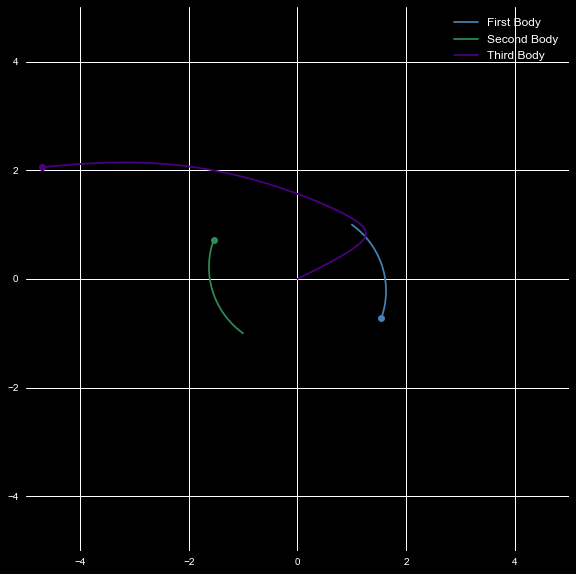

Final pos: -4.70675672705922 2.0533702652889545
(10, 100)
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          8.83e+00       3.74e+01          100            198      
       2          6.47e+00       5.17e-01          298            559      
       3          1.68e+02       1.62e+00          857           1712      
       4          2.08e+03       1.21e+00         2569           5136      
       5          4.84e+04       4.84e-01         7705          (15408)    
Number of nodes is exceeded after iteration 5. 
Maximum relative residual: 4.84e+04 
Maximum boundary residual: 4.84e-01


In [166]:
sol, sol2 = attempt_solve()

t_f = 4.122518122254198


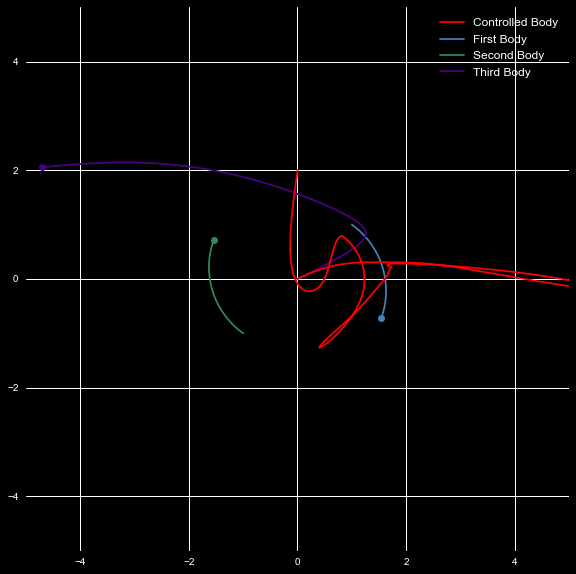

In [167]:
print("t_f =", sol2.p[0])
plt.style.use("dark_background")
plt.plot(sol2.y[0], sol2.y[1], color = 'red', zorder=15, label="Controlled Body")
ax = plt.gca()
plot_solution(sol.y, "", ax=ax, show_speed=False)